In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import string
import os
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import random
import io
import sys
import warnings
from PIL import Image, ImageDraw, ImageFont
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import time 

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from collections import Counter

warnings.filterwarnings("ignore")


In [2]:
data = pd.read_csv('/Users/killuaa/Desktop/LSTM/Song/music.csv')
data = data.drop(columns=['link'])

In [3]:
data.head()

,artist,song,text
0,ABBA,Ahe's My Kind Of Girl,"Look at her face, it's a wonderful face \r\nA..."
1,ABBA,"Andante, Andante","Take it easy with me, please \r\nTouch me gen..."
2,ABBA,As Good As New,I'll never know why I had to go \r\nWhy I had...
3,ABBA,Bang,Making somebody happy is a question of give an...
4,ABBA,Bang-A-Boomerang,Making somebody happy is a question of give an...


In [4]:
print("Artist:\n ", data.artist.value_counts()) 

Artist:
  artist
Donna Summer        191
Gordon Lightfoot    189
Bob Dylan           188
George Strait       188
Loretta Lynn        187
                   ... 
Zazie                 2
Zed                   1
Zoe                   1
X-Treme               1
U-Kiss                1
Name: count, Length: 643, dtype: int64


In [5]:
data.shape

(57650, 3)

Some Feature Engineering to extract some mmore information from the data

In [6]:
'''
Calculate the total number of characters in each song's text
This simply counts all characters (including spaces, punctuation, etc.)
-----
Calculate the total number of words in each song
This first tokenizes the text using NLTK's word_tokenizer (splitting text into individual words)
Then counts how many tokens/words exist for each song
------
Calculate the number of lines in each song
This counts how many newline characters (\n) appear in the text
A good proxy for counting verses, chorus sections, etc.
'''

data["No_of_Characters"] = data["text"].apply(len)
data["No_of_Words"] = data.apply(lambda row: nltk.word_tokenize(row["text"]), axis=1).apply(len)
data["No_of_Lines"] = data["text"].apply(lambda x: x.count("\n"))
data.describe()

,No_of_Characters,No_of_Words,No_of_Lines
count,57650.000000,57650.000000,57650.000000
mean,1220.616184,251.066956,41.111292
std,592.432453,129.858246,19.478674
min,410.000000,39.000000,7.000000
25%,813.000000,163.000000,27.000000
50%,1090.000000,221.000000,37.000000
75%,1463.750000,301.000000,50.000000
max,4186.000000,1061.000000,251.000000


In [7]:
# Find the top 15 artists with the most songs
top_15_artists = data['artist'].value_counts().nlargest(15).index.tolist()

for artist in top_15_artists:
    print(artist)

filtered_data = data[data['artist'].isin(top_15_artists)]

Donna Summer
Gordon Lightfoot
Bob Dylan
George Strait
Loretta Lynn
Cher
Alabama
Reba Mcentire
Chaka Khan
Dean Martin
Hank Williams Jr.
Neil Young
Nazareth
Cliff Richard
America


<Figure size 600x500 with 0 Axes>

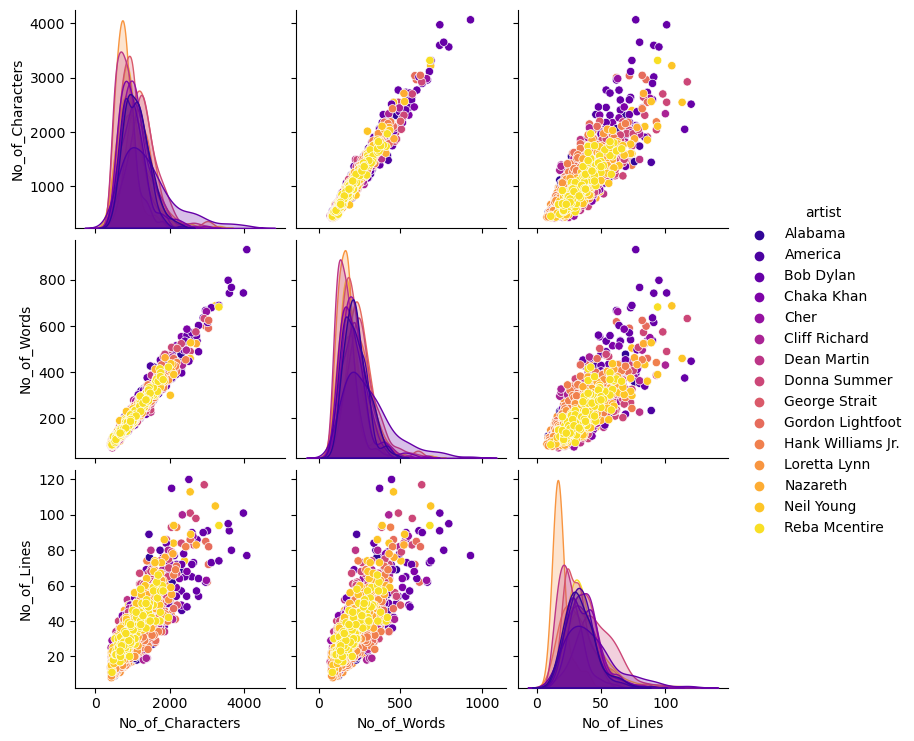

In [8]:
# Plot the number of characters, words and lines for each artist
plt.figure(figsize=(6, 5))
ax = sns.pairplot(filtered_data, hue="artist", palette="plasma")

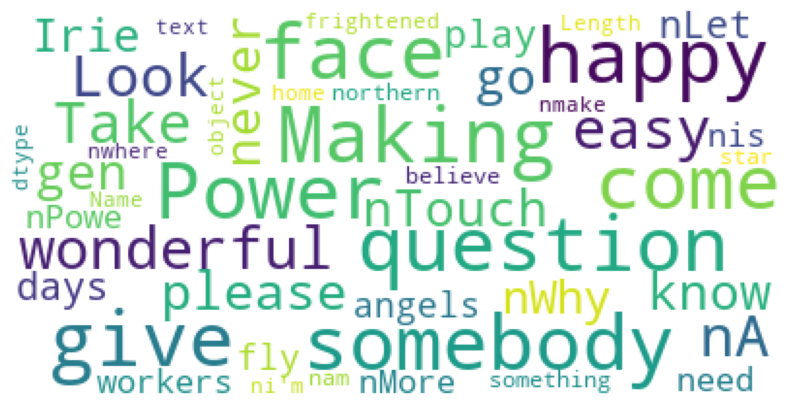

In [9]:
stopwords = set(STOPWORDS)
wordcloud = WordCloud(
    background_color='white',
    stopwords=stopwords,
    max_words=500,
    max_font_size=40,
    random_state=42
).generate(str(data['text']))
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [10]:
def display_lyrics(text, title="Song"):
    print(f"=== {title} ===")
    print(text)
    print("="*20)
    
display_lyrics(data.text[2][:600])

=== Song ===
I'll never know why I had to go  
Why I had to put up such a lousy rotten show  
Boy, I was tough, packing all my stuff  
Saying I don't need you anymore, I've had enough  
And now, look at me standing here again 'cause I found out that  
Ma ma ma ma ma ma ma ma ma ma ma ma ma ma ma ma my life is here  
Gotta have you near  
  
As good as new, my love for you  
And keeping it that way is my intention  
As good as new and growing too  
Yes, I think it's taking on a new dimension  
It's as good as new, my love for you  
Just like it used to be and even better  
As good as new, than


Data Preprocessing

In [11]:
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove special characters, numbers, and extra whitespace
    text = re.sub(r'[^\w\s\'.,!?\n]', ' ', text)  # Keep apostrophes, periods, commas, etc.
    text = re.sub(r'\d+', ' ', text)      # Replace numbers with space
    text = re.sub(r'\s+', ' ', text)      # Replace multiple spaces with single space
    
    # Optional: Remove stopwords
    # Note: For lyrics generation, we might want to keep stopwords as they're important for flow
    # stop_words = set(stopwords.words('english'))
    # tokens = nltk.word_tokenize(text)
    # text = ' '.join([word for word in tokens if word not in stop_words])
    
    # Optional: Lemmatization 
    # lemmatizer = WordNetLemmatizer()
    # tokens = nltk.word_tokenize(text)
    # text = ' '.join([lemmatizer.lemmatize(word) for word in tokens])
    
    return text.strip()

data['better_lyrics'] = data['text'].apply(preprocess_text)


In [12]:
data['better_lyrics']

0        look at her face, it's a wonderful face and it...
1        take it easy with me, please touch me gently l...
2        i'll never know why i had to go why i had to p...
3        making somebody happy is a question of give an...
4        making somebody happy is a question of give an...
                               ...                        
57645    irie days come on play let the angels fly let ...
57646    power to the workers more power power to the w...
57647    all you need is something i'll believe flashli...
57648    northern star am i frightened where can i go t...
57649    come in make yourself at home i'm a bit late h...
Name: better_lyrics, Length: 57650, dtype: object

In [13]:
tokenization_type = "word"  # Options: "char" or "word"

# Character-level tokenization function
def char_tokenize(text):
    """Convert text to list of characters"""
    return list(text)

# Word-level tokenization function
def word_tokenize(text):
    """Convert text to list of words"""
    return text.split()

# Apply tokenization based on selected approach
if tokenization_type == "char":
    # Character-level tokenization
    data['tokenized'] = data['better_lyrics'].apply(char_tokenize)
    print("Using character-level tokenization")
else:
    # Word-level tokenization
    data['tokenized'] = data['better_lyrics'].apply(word_tokenize)
    print("Using word-level tokenization")


Using word-level tokenization


In [14]:
# Flatten all tokens into a single list
all_tokens = [token for tokens in data['tokenized'] for token in tokens]
print(f"Total tokens: {len(all_tokens)}")

# Count token frequencies
token_counts = Counter(all_tokens)
print(f"Unique tokens: {len(token_counts)}")

# Create vocabulary (keep only tokens appearing at least min_freq times)
min_freq = 2
vocab = ['<PAD>', '<UNK>']  # Special tokens
vocab.extend([token for token, count in token_counts.items() if count >= min_freq])

# Create token-to-index and index-to-token mappings
token2idx = {token: idx for idx, token in enumerate(vocab)}
idx2token = {idx: token for idx, token in enumerate(vocab)}

print(f"Vocabulary size: {len(vocab)}")

Total tokens: 12691959
Unique tokens: 136149
Vocabulary size: 74366


In [15]:
sequence_length = 50  # Input sequence length
step_size = 1         # Step size for sliding window

def create_sequences(tokenized_text, seq_length, step):
    """Create input-output sequences from tokenized text"""
    sequences = []
    targets = []
    
    # Convert tokens to indices, replacing rare tokens with <UNK>
    indices = [token2idx.get(token, token2idx['<UNK>']) for token in tokenized_text]
    
    # Create sequences and corresponding targets
    for i in range(0, len(indices) - seq_length, step):
        seq = indices[i:i + seq_length]
        target = indices[i + seq_length]
        sequences.append(seq)
        targets.append(target)
    
    return sequences, targets


In [ ]:
all_sequences = []
all_targets = []

for tokens in data['tokenized']:
    # Only use sequences that are long enough
    if len(tokens) > sequence_length + 1:
        seqs, tgts = create_sequences(tokens, sequence_length, step_size)
        all_sequences.extend(seqs)
        all_targets.extend(tgts)

print(f"Total sequences: {len(all_sequences)}")

In [17]:
class LyricsDataset(Dataset):
    """PyTorch Dataset for lyrics generation"""
    
    def __init__(self, sequences, targets):
        self.sequences = sequences
        self.targets = targets
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return (
            torch.tensor(self.sequences[idx], dtype=torch.long),
            torch.tensor(self.targets[idx], dtype=torch.long)
        )

# Create dataset and dataloader
dataset = LyricsDataset(all_sequences, all_targets)


In [ ]:
# Sample only 20% of sequences to reduce training time
num_samples = min(int(len(all_sequences) * 0.2), 10000)  # Cap at 10,000 samples
sample_indices = np.random.choice(len(all_sequences), size=num_samples, replace=False)
sampled_sequences = [all_sequences[i] for i in sample_indices]
sampled_targets = [all_targets[i] for i in sample_indices]

print(f"Reduced dataset from {len(all_sequences)} to {len(sampled_sequences)} sequences")

# Create dataset from sampled data
dataset = LyricsDataset(sampled_sequences, sampled_targets)

# Split into train and validation sets (90% train, 10% validation)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create DataLoaders with larger batch size
batch_size = 256  # Increased from 64 to 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

print(f"Train batches: {len(train_loader)}, Validation batches: {len(val_loader)}")

# Vocabulary size (for model creation)
vocab_size = len(vocab)

Train batches: 137946, Validation batches: 15328


Model Creation 

In [19]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout=0.5):
        super(LSTMModel, self).__init__()
        
        # Embedding layer to convert token indices to vectors
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # LSTM layers
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True
        )
        
        # Dropout for regularization
        self.dropout = nn.Dropout(dropout)
        
        # Output layer
        self.fc = nn.Linear(hidden_dim, vocab_size)
    
    def forward(self, x, hidden=None):
        # x shape: [batch_size, sequence_length]
        
        # Get embeddings
        embedded = self.embedding(x)  # [batch_size, sequence_length, embedding_dim]
        
        # Pass through LSTM
        lstm_out, hidden = self.lstm(embedded, hidden)
        # lstm_out shape: [batch_size, sequence_length, hidden_dim]
        
        # Apply dropout
        lstm_out = self.dropout(lstm_out)
        
        # Reshape for final layer
        output = self.fc(lstm_out)
        # output shape: [batch_size, sequence_length, vocab_size]
        
        # For next token prediction, we only need the last prediction
        output = output[:, -1, :]  # [batch_size, vocab_size]
        
        return output, hidden
    
    def init_hidden(self, batch_size, device):
        # Initialize hidden state and cell state
        return (torch.zeros(self.lstm.num_layers, batch_size, self.lstm.hidden_size).to(device),
                torch.zeros(self.lstm.num_layers, batch_size, self.lstm.hidden_size).to(device))

In [ ]:
embedding_dim = 128    # Size of token embeddings
hidden_dim = 256       # LSTM hidden dimension
num_layers = 1         # Number of LSTM layers
dropout_rate = 0.5     # Dropout probability
learning_rate = 0.001  # Learning rate
num_epochs = 1         # Number of training epochs
clip_value = 5.0       # Gradient clipping value

# Set device (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Initialize model
model = LSTMModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    num_layers=num_layers,
    dropout=dropout_rate
).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


Using device: cpu


In [28]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, clip_value, device):
    """Train the LSTM model"""
    
    # Track metrics
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    
    # For early stopping
    patience = 3
    counter = 0
    
    for epoch in range(num_epochs):
        start_time = time.time()
        
        # Training phase
        model.train()
        train_loss = 0.0
        
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Initialize hidden state
            hidden = model.init_hidden(inputs.size(0), device)
            
            # Forward pass
            optimizer.zero_grad()
            output, _ = model(inputs, hidden)
            loss = criterion(output, targets)
            
            # Backward pass
            loss.backward()
            
            # Gradient clipping to prevent exploding gradients
            nn.utils.clip_grad_norm_(model.parameters(), clip_value)
            
            # Update weights
            optimizer.step()
            
            train_loss += loss.item()
            
            # Print progress
            if (batch_idx + 1) % 50 == 0:
                print(f'Epoch {epoch+1}/{num_epochs}, Batch {batch_idx+1}/{len(train_loader)}, Loss: {loss.item():.4f}')
        
        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                
                # Initialize hidden state
                hidden = model.init_hidden(inputs.size(0), device)
                
                # Forward pass
                output, _ = model(inputs, hidden)
                loss = criterion(output, targets)
                val_loss += loss.item()
        
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        epoch_time = time.time() - start_time
        
        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {avg_train_loss:.4f}, '
              f'Val Loss: {avg_val_loss:.4f}, '
              f'Time: {epoch_time:.2f}s')
        
        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_lyrics_model.pt')
            counter = 0
        else:
            counter += 1
        
        # Early stopping
        if counter >= patience:
            print(f'Early stopping after {epoch+1} epochs')
            break
    
    return train_losses, val_losses


In [ ]:
train_losses, val_losses = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs,
    clip_value=clip_value,
    device=device
)

Epoch 1/1, Batch 50/137946, Loss: 7.7771
Epoch 1/1, Batch 100/137946, Loss: 7.2163


KeyboardInterrupt: 